# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [4]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from data_utils import get_id_type_list_for_class, OUTPUT_PATH, GENERATED_DATA, to_set, RESOURCES_PATH
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

Using TensorFlow backend.


In [14]:
from models.squeezenet_multiclassification import get_squeezenet21_rare_tags

from sklearn.model_selection import KFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import load_pretrained_model, get_label
from data_utils import DataCache

from xy_providers import image_class_labels_provider
from models.keras_metrics import binary_crossentropy_with_false_negatives


# Setup configuration

seed = 2017
np.random.seed(seed)

cache = DataCache(0)  # !!! CHECK BEFORE LOAD TO FLOYD

class_index = 0

trainval_id_type_list = get_id_type_list_for_class(class_index)


### ADD GENERATED IMAGES
from glob import glob
from data_utils import GENERATED_DATA, to_set, get_label

gen_train_jpg_files = glob(os.path.join(GENERATED_DATA, "train", "jpg", "*.jpg"))
gen_train_jpg_ids = [s[len(os.path.join(GENERATED_DATA, "train", "jpg"))+1+len('gen_train_'):-4] for s in gen_train_jpg_files]
gen_id_type_list = [(image_id, "Generated_Train_jpg") for image_id in gen_train_jpg_ids]
class_index_gen_train_jpg_ids = [id_type for id_type in gen_train_jpg_ids if np.sum(get_label(*gen_id_type_list[0], class_index=class_index)) > 0]
class_index_gen_id_type_list = [(image_id, "Generated_Train_jpg") for image_id in class_index_gen_train_jpg_ids]
trainval_id_type_list = trainval_id_type_list + class_index_gen_id_type_list
### ADD GENERATED IMAGES

class_indices = list(equalized_data_classes.keys())
class_indices.remove(class_index)

n_other_samples = int(len(trainval_id_type_list) * 1.0 / len(class_indices))

for index in class_indices:
    id_type_list = np.array(get_id_type_list_for_class(index))
    id_type_list = list(to_set(id_type_list) - to_set(trainval_id_type_list))
    np.random.shuffle(id_type_list)
    trainval_id_type_list.extend(id_type_list[:n_other_samples])

print(len(trainval_id_type_list), len(to_set(trainval_id_type_list)))

13724 13724


In [15]:
params = {
    'seed': seed,

    'xy_provider': image_class_labels_provider,

    'network': get_squeezenet21_rare_tags,
    'network_kwargs': {
        'input_shape': (256, 256, 3),
        'weights': 'imagenet'
    },
    'n_classes': len(equalized_data_classes[class_index]),
    'image_size': (256, 256),

    'optimizer': 'adadelta',
    'loss': lambda Y_true, Y_pred: binary_crossentropy_with_false_negatives(Y_true, Y_pred, a=100.0),
    'nb_epochs': 50,    # !!! CHECK BEFORE LOAD TO FLOYD
    'batch_size': 16,  # !!! CHECK BEFORE LOAD TO FLOYD

    'normalize_data': True,
    'normalization': 'vgg',


    # Learning rate scheduler
    'lr_kwargs': {
        'lr': 0.01,
        'a': 0.95,
        'init_epoch': 0
    },
    'lr_decay_f': exp_decay,

    # Reduce learning rate on plateau
    'on_plateau': True,
    'on_plateau_kwargs': {
        'monitor': 'val_loss',
        'factor': 0.1,
        'patience': 2,
        'verbose': 1
    },

    'cache': cache,

    'class_index': class_index,
    # 'pretrained_model': 'load_best',
    # 'pretrained_model': os.path.join(GENERATED_DATA, "resources", ""),
    # 'pretrained_model_template': os.path.join(RESOURCES_PATH,
    #                                           "SqueezeNet21_all_classes_fold={fold_index}_seed=2017_40_val_loss=0.1216_val_precision=0.9153_val_recall=0.8670.h5"),

    'output_path': OUTPUT_PATH,
}

params['save_prefix_template'] = '{cnn_name}_classe=%i_fold={fold_index}_seed=%i' % (params['class_index'], params['seed'])


In [16]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]  # !!! CHECK BEFORE LOAD TO FLOYD
hists = []

kf = KFold(n_splits=n_folds)
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue            
            
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    break

In [12]:
train_id_type_list[0]

'18077_18691'

In [9]:
to_set(train_id_type_list) & to_set(val_id_type_list)

{('1', '8')}

In [75]:
from training_utils import get_id_imgaug_seq, get_gen_flow

In [76]:
loop_max_counter = -1
n_limit = -1

imgaug_seq = get_id_imgaug_seq()
train_gen, train_flow = get_gen_flow(id_type_list=train_id_type_list, imgaug_seq=imgaug_seq, test_mode=True, **params)
counter = 0
y_true = np.zeros((len(train_id_type_list), len(equalized_data_classes[class_index])))
for x, y, info in train_flow:
            
    y_true[counter*params['batch_size']:(counter+1)*params['batch_size']] = y
    counter += 1

    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

In [77]:
y_true.shape

(1114, 6)

In [78]:
import pandas as pd

In [79]:
df = pd.DataFrame(y_true, columns=equalized_data_classes[class_index])

In [80]:
from data_utils import TRAIN_ENC_CSV

def compute_stats(tags=None, train_enc_csv=TRAIN_ENC_CSV):
    if tags is None:
        tags = unique_tags
    tags_stats = {}
    for l in tags:
        tags_stats[l] = train_enc_csv[l].sum()
    return tags_stats

tags_stats = compute_stats(equalized_data_classes[class_index], train_enc_csv=df)

In [81]:
np.sum(list(tags_stats.values()))

1134.0

<Container object of 6 artists>

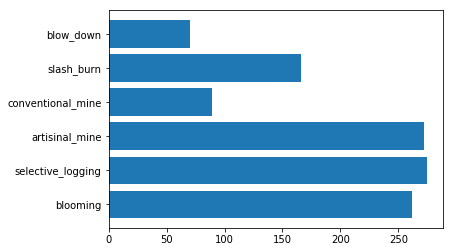

In [82]:
plt.barh(bottom=range(len(tags_stats.keys())), width=tags_stats.values(), tick_label=tags_stats.keys())

In [10]:
# Start CV

n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]  # !!! CHECK BEFORE LOAD TO FLOYD
hists = []

kf = KFold(n_splits=n_folds)
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue

    params['samples_per_epoch'] = 5 * len(train_id_type_list)
    params['nb_val_samples'] = int(1.5 * len(val_id_type_list))

    val_fold_index += 1
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

    cnn = params['network'](lr=params['lr_kwargs']['lr'], **params, **params['network_kwargs'])
    params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))

    if 'pretrained_model' in params:
        load_pretrained_model(cnn, **params)
    elif 'pretrained_model_template' in params:
        params['pretrained_model'] = params['pretrained_model_template'].format(fold_index=(val_fold_index-1) % 3)
        print((val_fold_index-1) % 3)
        print(params['pretrained_model'])
        load_pretrained_model(cnn, by_name=True, **params)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  1 / 5
2017-07-14 17:23:38.057107 2228 557

 2017-07-14 17:23:39.296927 - Loaded SqueezeNet21_rare_tags model ...

 2017-07-14 17:23:39.297030 - Start training ...

-- Training parameters: 16, 50, 11152, 848

-- Fit model
- New Keras API found -


In [ ]:
# ### Validation all classes

n_runs = 2
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = []  # !!! CHECK BEFORE LOAD TO FLOYD

params['pretrained_model'] = 'load_best'

_trainval_id_type_list = np.array(trainval_id_type_list)

while run_counter < n_runs:
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in kf.split(_trainval_id_type_list):
        train_id_type_list, val_id_type_list = _trainval_id_type_list[train_index], _trainval_id_type_list[test_index]

        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue

        val_fold_index += 1
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))

        load_pretrained_model(cnn, **params)

        params['seed'] += run_counter - 1

        f2, mae = validate(cnn, val_id_type_list, verbose=0, **params)
        cv_mean_scores[run_counter-1, val_fold_index-1] = f2

        np.random.shuffle(_trainval_id_type_list)

print(cv_mean_scores)
